In [1]:
#Imported all the necessary libraries
import pandas as pd
from numpy.linalg import inv,det
import math as mth
from collections import Counter
from math import log
from scipy.special import comb
from sklearn.cross_validation import KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
#Importing the Iris dataset
data_df = pd.read_csv('iris.dat',header= None)
data_df.columns = ['A', 'B', 'C', 'D', 'E']
#Creating the 2 class dataset
two_class = data_df[((data_df.E=='Iris-setosa') == True) | ((data_df.E== 'Iris-versicolor') == True)]

In [3]:
data_df1 = data_df.copy()

In [4]:
two_class.head()

,A,B,C,D,E
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
#Calculating the accuracy of the classifier
def accuracy(predicted,actual):
    tot = 0
    for i in range(len(predicted)):
        if predicted[i] == actual[i]:
            tot += 1
    acc = round(1. *tot/len(predicted),5)
    #print "Accuracy: ",acc
    return acc
#Calculating the Statistics : Precision, Recall, F-measure & Confusion Matrix.
def precision_recall(predicted,actual,typ,classes):
    count_classes = (Counter(predicted)) #Predicted Class distribution
    count_classes1 = (Counter(actual))   #Actual Class distribution
    #print dict(count_classes1)
    #print dict(count_classes)
    precision = []
    recall = []
    f_measure = []
    fprt = []
    cm = []
    for i in range(len(classes)):
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for j in range(len(predicted)):
            if ((predicted[j] == classes[i]) and (actual[j] == classes[i])):
                tp += 1
            elif ((predicted[j] == classes[i]) and (actual[j] != classes[i])):
                fp += 1
            elif ((predicted[j] != classes[i]) and (actual[j] == classes[i])):
                fn += 1
            elif ((predicted[j] != classes[i]) and (actual[j] != classes[i])):
                tn += 1
        if tp == 0:
            prec = 0
            rec = 0
            f_msr = 0
        else:
        
            prec = 1. *tp / (tp + fp) #Precision Calculation
            rec = 1. * tp / (tp + fn) #Recall Calculation
            f_msr = 2/((1/prec) + (1/rec)) #F-measure Calculation
            
        if fp ==0:
            fpr = 0
        else:
            fpr = (1. *fp / (fp + tn))
            
        fprt.append(fpr)
        cm.append((classes[i],tp,tn,fp,fn))
        precision.append(prec)
        recall.append(rec)
        f_measure.append(f_msr)
    return(dict(count_classes1),dict(count_classes),np.mean(precision),np.mean(recall),np.mean(f_measure),np.mean(fprt),cm)
    

In [6]:
#Creating a list that would be used for the stats calculation. This function would return 2 lists in total wiz the predicted and the actual class.
def create_final(y_predicted,y_actual):
    final_predicted = []
    final_actual = []
    for i in range(len(y_predicted)):
        for j in range(len(y_predicted[i])):
            final_predicted.append(y_predicted[i][j])
            final_actual.append(y_actual[i][j])
    return(final_predicted,final_actual)

In [7]:
#Assigning the suitable class This function would be used for the N dimension K class classification
def assign_classes(x):
    zipped_list = [i for i in list(zip(*x))]
    predicted = []
    for i in range(len(zipped_list)):
        if i == 0:
            continue
        tolist =  list(zipped_list[i])
        val = max(zipped_list[i])
        index = zipped_list[i].index(val)
        predicted.append(zipped_list[0][index])
    return predicted

In [8]:
#Implementing the discriminant function which would be used for 2 class classification
def discriminant_func(x,y_test,threshold):
    g1 = x[0][1:]
    g2 = x[1][1:]
    y_predicted = []
    res = [g1[i] - g2[i] for i in range(len(g1))]
    #print threshold
    for i in range(len(res)):
        if res[i]> threshold:
            y_predicted.append(x[0][0])
        else:
            y_predicted.append(x[1][0])
    return y_predicted

In [9]:
#Calculating the likelihood formulae in this function. THis would be used for the 1-dimension 2 class classifier.
def do_classification(X_test,y_test,classes,params,typ):
    final = []
    
    for i in range(len(params)):
        for j in classes:
            if params[i][0] == j:
                gen_func = []
                gen_func.append(j)
                for k in range(len(X_test)):
                    prob = -mth.log(params[i][3]) + mth.log(params[i][1]) - ((X_test[k] - params[i][2]) ** 2)/ (2*(params[i][3])**2)
                    gen_func.append(prob)
                final.append(gen_func)
    return final

In [10]:
#Calculating the likelihood formulae in this function. THis would be used for the n-dimension 2 & the n dimension k class classifier.
def do_classification1(X_test,y_test,classes,params,typ):
    
    final = []
    for i in range(len(params)):
        for j in classes:
            if params[i][0] == j:
                gen_func = []
                gen_func.append(j)
                for k in range(len(X_test)):
                    calc = 0.5*(np.dot((X_test[k] - params[i][2]),inv(params[i][3])))
                    prob = -log(det(params[i][3])) - np.dot(calc,np.transpose(X_test[k] - params[i][2])) + mth.log(params[i][1])            
                    gen_func.append(prob)
                final.append(gen_func)
    return final

In [11]:
#Computing mu and sigma/covariance-matrix
def mu_sigma(data,y,classes,typ):
    counts = dict(Counter(y))
    params = []
    for cls in classes:
        index = [ind for ind,i in enumerate(y) if i == cls]
        X = data[index]
        cnt = counts[cls]
        sum1 = []
        mu = []
        summ = 0
        if typ == '1D':
            for i in range(len(X)):
                summ += X[i]
            mu  = summ/cnt
            var_ele = [(i-mu)**2 for i in X]
            variance = sum(var_ele)/cnt
            params.append((cls,1.*cnt/len(data),mu,variance))
    
        else:
            
            for i in range(len(X)):
                summ += X[i]
                sum1.append(summ)
            _mu_ = (1.* 1/cnt) * summ
            mu.append(_mu_)
            
            data1 = [i for i in zip(*X)]
            covariance = []
            for k in range(len(data1)):
                cov = []
                for l in range(len(data1)):
                    ele1 = [i - mu[0][k] for i in data1[k]]
                    ele2 = [i - mu[0][l] for i in data1[l]]
                    prod_ele = [i*j for i,j in zip(ele1,ele2)]
                    cov.append((sum(prod_ele)/cnt).tolist())
                covariance.append(cov)
            params.append((cls,1.*cnt/len(data),mu,covariance))
    return params

 1-Dimension 2 classs GDA
--------------------------
Classes:  ['Iris-setosa', 'Iris-versicolor']
Actual class distributions:  {'Iris-setosa': 50, 'Iris-versicolor': 50}
Predicted class distributions:  {'Iris-setosa': 43, 'Iris-versicolor': 57}
Classes,TP,TN,FP,FN
Confusion Matrix for every class [('Iris-setosa', 38, 45, 5, 12), ('Iris-versicolor', 45, 38, 12, 5)]
Accuracy:  0.83
Average Precision of all the classes:  0.836597307222
Average Recall of all the classes:  0.83
Average F-measure of all the classes:  0.829162898201


/root/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


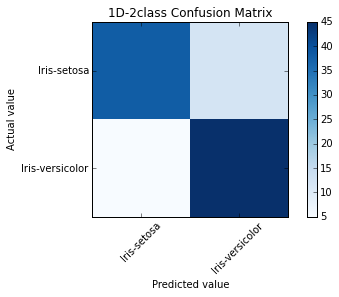

***********************************************************************************


n_dimension_GDA_kclass
----------------------
Classes:  ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Actual class distributions:  {'Iris-virginica': 50, 'Iris-setosa': 50, 'Iris-versicolor': 50}
Predicted class distributions:  {'Iris-virginica': 52, 'Iris-setosa': 50, 'Iris-versicolor': 48}
Classes,TP,TN,FP,FN
Confusion Matrix for every class [('Iris-setosa', 50, 100, 0, 0), ('Iris-versicolor', 47, 99, 1, 3), ('Iris-virginica', 49, 97, 3, 1)]
Accuracy:  0.97333
Average Precision of all the classes:  0.973824786325
Average Recall of all the classes:  0.973333333333
Average F-measure of all the classes:  0.973322662398


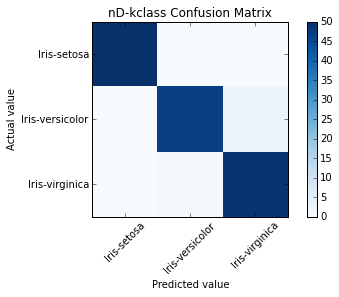

************************************************************************************


n_dimension_GDA_2class
----------------------
Classes:  ['Iris-setosa', 'Iris-versicolor']
Actual class distributions:  {'Iris-setosa': 50, 'Iris-versicolor': 50}
Predicted class distributions:  {'Iris-setosa': 50, 'Iris-versicolor': 50}
Classes,TP,TN,FP,FN
Confusion Matrix for every class [('Iris-setosa', 50, 50, 0, 0), ('Iris-versicolor', 50, 50, 0, 0)]
Accuracy:  1.0
Average Precision of all the classes:  1.0
Average Recall of all the classes:  1.0
Average F-measure of all the classes:  1.0


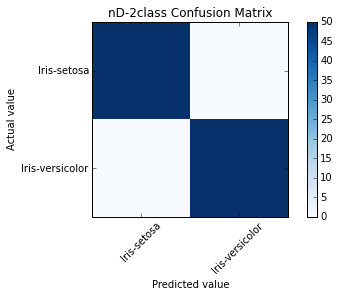

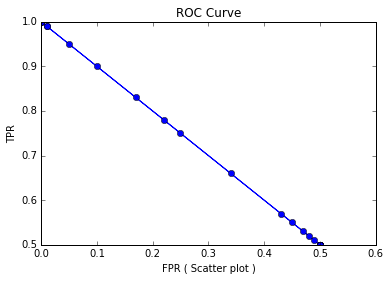

************************************************************************************


In [12]:
#Function for plotting the confusion matrix
def plot_confusion_matrix(classes,cm, title,cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Actual value')
    plt.xlabel('Predicted value')

#Function used for cross validation. 
def do_cross_validation_nd(sample,n_folds = 10,typ ='nD3',threshold=0):
        if typ == '1D':
            X = np.asarray(sample['A'])
        else:
            X = np.asarray(sample.iloc[:,:sample.shape[1]-1])
        y = np.asarray(sample['E'])
        sample.drop_duplicates(cols = 'E', inplace = True)
        classes = sample['E'].tolist()
        cv = KFold(len(y), n_folds,shuffle = True)
        params = []
        y_test = []
        y_actual = []
        y_predicted = []
        #print threshold
        for train_ind,test_ind in cv:
            y_test.append((y[test_ind]).tolist())
            params = mu_sigma(X[train_ind],y[train_ind],classes,typ )
            if typ == '1D':
                x = do_classification(X[test_ind],y[test_ind],classes,params,typ)
            else:
                x = do_classification1(X[test_ind],y[test_ind],classes,params,typ)
            if typ != 'nD3':
         
                y_predicted.append(discriminant_func(x,y[test_ind],threshold))
            else:
                y_predicted.append(assign_classes(x))
            y_actual.append(y[test_ind].tolist())
        return(y_predicted,y_actual,classes)

def one_dimension_GDA_2class(): 
    print " 1-Dimension 2 classs GDA"
    print "--------------------------"
    vals = do_cross_validation_nd(two_class.copy(),typ = '1D',threshold = 0) 
    final_list = create_final(vals[0],vals[1])
    accuracy_msr = accuracy(final_list[0],final_list[1])
    stats = precision_recall(final_list[0],final_list[1],typ = '1D',classes = vals[2])
    print "Classes: ",vals[2]
    print "Actual class distributions: ",stats[0]
    print "Predicted class distributions: ",stats[1]
    print "Classes,TP,TN,FP,FN"
    print "Confusion Matrix for every class", stats[6]
    print "Accuracy: ",accuracy_msr
    print "Average Precision of all the classes: ",stats[2]
    print "Average Recall of all the classes: ", stats[3]
    print "Average F-measure of all the classes: ", stats[4]
    cm = confusion_matrix(final_list[1], final_list[0])
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(vals[2],cm,title ='1D-2class Confusion Matrix')
    plt.show()
    print "***********************************************************************************"
    print "\n"
one_dimension_GDA_2class()

def n_dimension_GDA_kclass(): 
    print "n_dimension_GDA_kclass"
    print "----------------------"
    vals = do_cross_validation_nd(data_df.copy(),typ = 'nD3',threshold = 0) 
    final_list = create_final(vals[0],vals[1])
    accuracy_msr = accuracy(final_list[0],final_list[1])
    stats = precision_recall(final_list[0],final_list[1],typ = 'nD3',classes = vals[2])
    print "Classes: ",vals[2]
    print "Actual class distributions: ",stats[0]
    print "Predicted class distributions: ",stats[1]
    print "Classes,TP,TN,FP,FN"
    print "Confusion Matrix for every class", stats[6]
    print "Accuracy: ",accuracy_msr
    print "Average Precision of all the classes: ",stats[2]
    print "Average Recall of all the classes: ", stats[3]
    print "Average F-measure of all the classes: ", stats[4]
    cm = confusion_matrix(final_list[1], final_list[0])
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(vals[2],cm,title ='nD-kclass Confusion Matrix')
    plt.show()
    print "************************************************************************************"
    print "\n"

def n_dimension_GDA_2class(): 
    print "n_dimension_GDA_2class"
    print "----------------------"
    vals = do_cross_validation_nd(two_class.copy(),typ = 'nD2') 
    final_list = create_final(vals[0],vals[1])
    accuracy_msr = accuracy(final_list[0],final_list[1])
    stats = precision_recall(final_list[0],final_list[1],typ = 'nD2',classes = vals[2])
    print "Classes: ",vals[2]
    print "Actual class distributions: ",stats[0]
    print "Predicted class distributions: ",stats[1]
    print "Classes,TP,TN,FP,FN"
    print "Confusion Matrix for every class", stats[6]
    print "Accuracy: ",accuracy_msr
    print "Average Precision of all the classes: ",stats[2]
    print "Average Recall of all the classes: ", stats[3]
    print "Average F-measure of all the classes: ", stats[4]
    cm = confusion_matrix(final_list[1], final_list[0])
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(vals[2],cm,title ='nD-2class Confusion Matrix')
    plt.show()
    #ROC Curve Logic
    fpr = []
    tpr = []
    for i in range(1000,-1000,-25):
        vals = do_cross_validation_nd(two_class.copy(),typ = 'nD2',threshold=i)
        final_list = create_final(vals[0],vals[1])
        stats = precision_recall(final_list[0],final_list[1],typ = 'nD2',classes = vals[2])
        fpr.append(stats[5])
        tpr.append(stats[3])
    plt.figure()
    #ROC Curve logic.
    plt.title('ROC Curve')
    plt.xlabel("FPR ( Scatter plot )")
    plt.ylabel("TPR")
    plt.axis([0.0, 0.6, 0.5, 1.0])
    #Plotting the scatter plot for checking the initial complexity.
    plt.plot(fpr, tpr,  '-o')
    plt.show()
    print "************************************************************************************"
n_dimension_GDA_kclass()
n_dimension_GDA_2class()

In [13]:
#Naive Bayes with bernoulli distributions and binomial distribution; spambase dataset UC Irvine
import pandas as pd
import math as mth
from sklearn.cross_validation import KFold
import numpy as np

In [14]:
data_df_spam = pd.read_csv('spambase.data',header= None)

In [15]:
data_df_spam.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1


In [16]:
spam_feat = data_df_spam.iloc[:,:48]


In [17]:
spam_feat.head()


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,...,0,0.06,0,0,0.12,0,0.06,0.06,0,0
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0


In [18]:
#Assigning column names.
spam_feat.columns = ['word_freq_make','word_freq_address','word_freq_all' ,'word_freq_3d' ,'word_freq_our' ,'word_freq_over','word_freq_remove' ,'word_freq_internet','word_freq_order'  ,'word_freq_mail','word_freq_receive','word_freq_will','word_freq_people' ,'word_freq_report' ,'word_freq_addresses','word_freq_free','word_freq_business','word_freq_email'  ,'word_freq_you' ,'word_freq_credit' ,'word_freq_your','word_freq_font','word_freq_000' ,'word_freq_money'  ,'word_freq_hp'  ,'word_freq_hpl' ,'word_freq_george' ,'word_freq_650' ,'word_freq_lab' ,'word_freq_labs','word_freq_telnet' ,'word_freq_857' ,'word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts'  ,'word_freq_pm'  ,'word_freq_direct' ,'word_freq_cs'  ,'word_freq_meeting', 'word_freq_original','word_freq_project','word_freq_re', 'word_freq_edu' ,'word_freq_table','word_freq_conference']

In [19]:
spam_binomial = spam_feat.copy()
spam_feat['target'] = data_df_spam.iloc[:,data_df_spam.shape[1]-1]

In [20]:
#Shuffling the rows in the data frame since 1's were on top and 0's on bottom.
spam_shuffled = spam_feat.iloc[np.random.permutation(len(spam_feat))]
spam_binomial.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference
0,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,...,0,0.06,0,0,0.12,0,0.06,0.06,0,0
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0,0.00,0,0,0.00,0,0.00,0.00,0,0


In [21]:
spam_shuffled.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,target
4445,0,0,0.08,0,0.00,0.17,0,0,0.00,0,...,0,0.08,0,0,0,0.00,0.59,0,0,0
3267,0,0,0.51,0,1.54,0.00,0,0,0.25,0,...,0,0.00,0,0,0,0.25,0.00,0,0,0
2741,0,0,0.00,0,0.00,0.00,0,0,0.00,0,...,0,0.00,0,0,0,0.00,0.00,0,0,0
2698,0,0,0.00,0,7.14,0.00,0,0,0.00,0,...,0,0.00,0,0,0,7.14,0.00,0,0,0
4380,0,0,0.00,0,0.00,0.00,0,0,0.00,0,...,0,0.00,0,0,0,0.00,1.02,0,0,0


In [22]:
#Creating the dataset so that the features follow a Benoulli distribution.
def susbtitute_nan(x):
    if x == 0:
        return (0)
    else:
        return 1
spam_scrubbed = spam_shuffled.applymap(susbtitute_nan)

In [23]:
spam_scrubbed.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,target
4445,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3267,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2698,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [24]:
#Creating the dataset so that the features follow a Binomial distribution. Assuming that the total number of words is 1000 for each email.
def susbtitute_word_freq(x):
    x = x*1000
    return x
#Creating the dataset so that the features follow a Binomial distribution.
spam_binomial_scrubbed = spam_binomial.applymap(susbtitute_word_freq)
#spam_binomial_scrubbed['w_total_words'] = 1000
spam_binomial_scrubbed['target'] = data_df_spam.iloc[:,data_df_spam.shape[1]-1]

In [25]:
spam_binomial_scrubbed.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,target
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,0,0,0,0,0,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,120,0,60,60,0,0,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,0,0,0,0,0,1


In [26]:
#Function for likelihood calculation
def do_classification_param(X_test,params,classes,typ):
    final_res = []
    if typ == 'bernoulli':
        for i in range(len(classes)):
            res = []
            for k in range(len(X_test)):
                g = 0
                for j in range(len(X_test[k])):
                    g += (X_test[k][j] * log(params[i][1][j])) + ((1 - X_test[k][j]) * log(1 - params[i][1][j])) + log(params[i][0])

                res.append(g)
            final_res.append(res)
    else:
        for i in range(len(classes)):
            res = []
            for k in range(len(X_test)):
                g = 0
                for j in range(len(X_test[k])):
                    g += log((comb(1000,X_test[k][j]))*(params[i][1][j]**X_test[k][j])*((1 - params[i][1][j]) ** (1000-X_test[k][j]))) 
                    +  log(params[i][0])                           
                res.append(g)
            final_res.append(res)
    
    return final_res
#Calculating the training parameters.                       
def calc_params(X,y,classes,typ):
    E = 0.001
    final_feat = [] 
    alpha_prior = []
    for j in classes:
        relevant_X = []
        for i in range(len(X)):
            if y[i] ==  j:
                relevant_X.append(X[i].tolist())
        final_feat.append(relevant_X)
    for i in range(len(classes)):
        alpha_prior.append(1.*len(final_feat[i])/len(y))
    final = []
    for i in range(len(classes)):
        data = [a for a in zip(*final_feat[i])]
        sum_feat = [sum(a) for a in data]
        if typ == 'binomial':
            final_sum_feat = [1.* (x + E)/(1000*(len(final_feat[i]) + 2*E)) for x in sum_feat]
        else:
            final_sum_feat = [1.* (x + E)/(len(final_feat[i]) + 2*E) for x in sum_feat]
        final.append((alpha_prior[i],final_sum_feat))
    return final
#Implementing the discriminant function
def disrciminative(result,y_test,classes):
    dis_result = []
    for i in range(len(result[0])):
        if result[0][i] > result[1][i]:
            dis_result.append(classes[0])
        else:
            dis_result.append(classes[1])
    return(dis_result)
            
#Implementing cross-validation with shuffling.   
def cross_validation(X,y,classes,typ,n_folds = 10):
    cv = KFold(len(y), n_folds,shuffle = False)
    result = []
    y_actual = []
    y_predicted = []
    for train_ind,test_ind in cv:
        params = calc_params(X[train_ind],y[train_ind],classes,typ)
        result = (do_classification_param(X[test_ind],params,classes,typ))
        discriminative_function = disrciminative(result,y[test_ind],classes)
        y_actual.append(discriminative_function)
        y_predicted.append(y[test_ind].tolist())
      
    return (y_actual,y_predicted)

Classes:  [0, 1]
Actual class distributions:  {0: 4305, 1: 296}
Predicted class distributions:  {0: 2788, 1: 1813}
Classes,TP,TN,FP,FN
Confusion Matrix for every class [(0, 2787, 295, 1, 1518), (1, 295, 2787, 1518, 1)]
Accuracy:  0.66985
Average Precision of all the classes:  0.581177527042
Average Recall of all the classes:  0.822004190602
Average F-measure of all the classes:  0.53279931857


/root/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


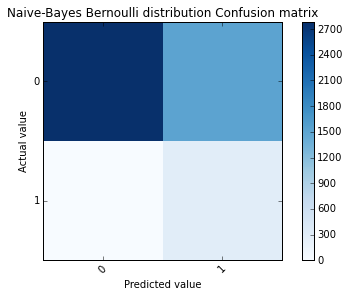

***********************************************************************************
Classes:  [1, 0]
Actual class distributions:  {0: 2850, 1: 1751}
Predicted class distributions:  {0: 2788, 1: 1813}
Classes,TP,TN,FP,FN
Confusion Matrix for every class [(1, 1520, 2557, 293, 231), (0, 2557, 1520, 231, 293)]
Accuracy:  0.88611
Average Precision of all the classes:  0.877767158281
Average Recall of all the classes:  0.882634183975
Average F-measure of all the classes:  0.880016713587


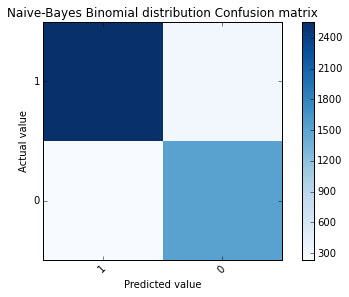

***********************************************************************************


In [29]:
#Main Function.
def main_func(sample,typ,title):
    #sample = spam_scrubbed.copy()
    sample.drop_duplicates(cols = 'target', inplace = True)
    sample['target'].count()
    X_calc = spam_scrubbed.copy()
    classes = sample['target'].tolist()
    X = X_calc.iloc[:,:X_calc.shape[1]-1].as_matrix().astype(np.int) #X array
    y = X_calc.iloc[:,-1].as_matrix().astype(np.int) # Target vars
    res = cross_validation(X,y,classes,typ)
    for_accuracy = create_final(res[1],res[0])
    accuracy_msr = accuracy(for_accuracy[0],for_accuracy[1])
    stats = precision_recall(for_accuracy[0],for_accuracy[1],typ = 'nD2',classes = classes)
    print "Classes: ",classes
    print "Actual class distributions: ",stats[0]
    print "Predicted class distributions: ",stats[1]
    print "Classes,TP,TN,FP,FN"
    print "Confusion Matrix for every class", stats[6]
    print "Accuracy: ",accuracy_msr
    print "Average Precision of all the classes: ",stats[2]
    print "Average Recall of all the classes: ", stats[3]
    print "Average F-measure of all the classes: ", stats[4]
    cm = confusion_matrix(for_accuracy[1], for_accuracy[0])
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(classes,cm,title =title)
    plt.show()
    print "***********************************************************************************"
main_func(spam_scrubbed.copy(),typ = 'bernoulli',title = 'Naive-Bayes Bernoulli distribution Confusion matrix')
main_func(spam_binomial_scrubbed.copy(),typ = 'binomial',title = 'Naive-Bayes Binomial distribution Confusion matrix')